# Examining Soccer Like a Data Analyst

## Loading the Data

In [1]:
# Begin by Importing the Packages
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import matplotlib.pyplot as plt 
import seaborn as sns
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [2]:
# Load the Fifa Dataset and take a first glimpse
fifa_data = pd.read_csv("FIFA19data.csv", engine = "python")
fifa_data.head()

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,International Reputation,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,158023,L. Messi,31,Argentina,94,94,FC Barcelona,€110.5M,€565K,5.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,20801,Cristiano Ronaldo,33,Portugal,94,94,Juventus,€77M,€405K,5.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,190871,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,€118.5M,€290K,5.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,193080,De Gea,27,Spain,91,93,Manchester United,€72M,€260K,4.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,192985,K. De Bruyne,27,Belgium,91,92,Manchester City,€102M,€355K,4.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [3]:
# Some of the columns are hidden in the previous table, so let's pull them out!
fifa_data.columns

Index(['ID', 'Name', 'Age', 'Nationality', 'Overall', 'Potential', 'Club',
       'Value', 'Wage', 'International Reputation', 'Weak Foot', 'Skill Moves',
       'Work Rate', 'Body Type', 'Position', 'Contract Valid Until',
       'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys',
       'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
       'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance',
       'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes'],
      dtype='object')

## Data Cleaning

In [4]:
# Check number of rows and columns in the dataset
fifa_data.shape

(18207, 50)

In [5]:
# Detect the null values in the Fifa dataset
fifa_data.isna().sum()

ID                            0
Name                          0
Age                           0
Nationality                   0
Overall                       0
Potential                     0
Club                        241
Value                         0
Wage                          0
International Reputation     48
Weak Foot                    48
Skill Moves                  48
Work Rate                    48
Body Type                    48
Position                     60
Contract Valid Until        289
Crossing                     48
Finishing                    48
HeadingAccuracy              48
ShortPassing                 48
Volleys                      48
Dribbling                    48
Curve                        48
FKAccuracy                   48
LongPassing                  48
BallControl                  48
Acceleration                 48
SprintSpeed                  48
Agility                      48
Reactions                    48
Balance                      48
ShotPowe

In [6]:
# To continue with our exercise, we need to resolve the null issue. Since the number of nulls 
# is quite small, we can simply eliminate them from the dataset (for variables of interest). 
fifa_data = fifa_data.dropna(subset=["International Reputation", "Weak Foot", "Skill Moves", 
                                     "Work Rate", "Crossing","Finishing"], how="all" )

In [7]:
# Check the number of rows and columns after removing the null values
fifa_data.shape

# We notice only 48 rows were removed

(18159, 50)

In [8]:
# Examine all columns / datatypes
fifa_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18159 entries, 0 to 18206
Data columns (total 50 columns):
ID                          18159 non-null int64
Name                        18159 non-null object
Age                         18159 non-null int64
Nationality                 18159 non-null object
Overall                     18159 non-null int64
Potential                   18159 non-null int64
Club                        17918 non-null object
Value                       18159 non-null object
Wage                        18159 non-null object
International Reputation    18159 non-null float64
Weak Foot                   18159 non-null float64
Skill Moves                 18159 non-null float64
Work Rate                   18159 non-null object
Body Type                   18159 non-null object
Position                    18147 non-null object
Contract Valid Until        17918 non-null object
Crossing                    18159 non-null float64
Finishing                   18159 non-nul

In [9]:
# Review summary of statistics
fifa_data.describe()

,ID,Age,Overall,Potential,International Reputation,Weak Foot,Skill Moves,Crossing,Finishing,HeadingAccuracy,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
count,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,...,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000
mean,214279.590286,25.122529,66.249904,71.319126,1.113222,2.947299,2.361308,49.734181,45.550911,52.298144,...,48.548598,58.648274,47.281623,47.697836,45.661435,16.616223,16.391596,16.232061,16.388898,16.710887
std,29968.461880,4.670568,6.914613,6.134420,0.394031,0.660456,0.756164,18.364524,19.525820,17.379909,...,15.704053,11.436133,19.904397,21.664004,21.289135,17.695349,16.906900,16.502864,17.034669,17.955119
min,16.000000,16.000000,46.000000,48.000000,1.000000,1.000000,1.000000,5.000000,2.000000,4.000000,...,5.000000,3.000000,3.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,200300.000000,21.000000,62.000000,67.000000,1.000000,3.000000,2.000000,38.000000,30.000000,44.000000,...,39.000000,51.000000,30.000000,27.000000,24.000000,8.000000,8.000000,8.000000,8.000000,8.000000
50%,221743.000000,25.000000,66.000000,71.000000,1.000000,3.000000,2.000000,54.000000,49.000000,56.000000,...,49.000000,60.000000,53.000000,55.000000,52.000000,11.000000,11.000000,11.000000,11.000000,11.000000
75%,236508.500000,28.000000,71.000000,75.000000,1.000000,3.000000,3.000000,64.000000,62.000000,64.000000,...,60.000000,67.000000,64.000000,66.000000,64.000000,14.000000,14.000000,14.000000,14.000000,14.000000
max,246620.000000,45.000000,94.000000,95.000000,5.000000,5.000000,5.000000,93.000000,95.000000,94.000000,...,92.000000,96.000000,94.000000,93.000000,91.000000,90.000000,92.000000,91.000000,90.000000,94.000000


In [10]:
# We notice that value / wages are not numeric type and notice some discrepancies in the currencies displayed.
# Adjust discrepancies with currencies first
fifa_data = fifa_data.replace("€ 0", "€0M")

In [11]:
# Strip the currencies from all values / wages
fifa_data['Value'] = fifa_data['Value'].str.slice(1,-1)
fifa_data['Wage'] = fifa_data['Wage'].str.slice(1,-1)

In [12]:
# Convert values / wages to numeric datatype
fifa_data['Value'] = pd.to_numeric(fifa_data['Value'], errors='coerce').fillna(0).astype(np.int64)
fifa_data['Wage'] = pd.to_numeric(fifa_data['Wage'], errors='coerce').fillna(0).astype(np.int64)

In [13]:
# Review summary of statistics again
fifa_data.describe()

# Notice values/wages are shown now

,ID,Age,Overall,Potential,Value,Wage,International Reputation,Weak Foot,Skill Moves,Crossing,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
count,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,...,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000
mean,214279.590286,25.122529,66.249904,71.319126,264.666777,9.752574,1.113222,2.947299,2.361308,49.734181,...,48.548598,58.648274,47.281623,47.697836,45.661435,16.616223,16.391596,16.232061,16.388898,16.710887
std,29968.461880,4.670568,6.914613,6.134420,289.960657,22.024398,0.394031,0.660456,0.756164,18.364524,...,15.704053,11.436133,19.904397,21.664004,21.289135,17.695349,16.906900,16.502864,17.034669,17.955119
min,16.000000,16.000000,46.000000,48.000000,0.000000,0.000000,1.000000,1.000000,1.000000,5.000000,...,5.000000,3.000000,3.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,200300.000000,21.000000,62.000000,67.000000,4.000000,1.000000,1.000000,3.000000,2.000000,38.000000,...,39.000000,51.000000,30.000000,27.000000,24.000000,8.000000,8.000000,8.000000,8.000000,8.000000
50%,221743.000000,25.000000,66.000000,71.000000,160.000000,3.000000,1.000000,3.000000,2.000000,54.000000,...,49.000000,60.000000,53.000000,55.000000,52.000000,11.000000,11.000000,11.000000,11.000000,11.000000
75%,236508.500000,28.000000,71.000000,75.000000,475.000000,9.000000,1.000000,3.000000,3.000000,64.000000,...,60.000000,67.000000,64.000000,66.000000,64.000000,14.000000,14.000000,14.000000,14.000000,14.000000
max,246620.000000,45.000000,94.000000,95.000000,975.000000,565.000000,5.000000,5.000000,5.000000,93.000000,...,92.000000,96.000000,94.000000,93.000000,91.000000,90.000000,92.000000,91.000000,90.000000,94.000000


## Preparing our Model Dataset

In [14]:
# Creates a new column based on contract valid until data. Contract Status is 1 when there is 
# a contract valid date and 0 if not
fifa_data['Contract_status'] = np.where(fifa_data['Contract Valid Until'].isna(), 0, 1)
fifa_data.loc[:, ['Contract_status']].sum()

Contract_status    17918
dtype: int64

In [15]:
# New column addition confirmed
fifa_data.shape

(18159, 51)

### Checking for correlations between variables

We will use Spearman's rank order correlation coefficient to examine correlations between variables. Our criteria will be based on two indicators: correlation and p-values. Correlations which have a significant p-value (lower than 0.05) and a correlation of > 0.5 will be considered strongly correlated.

In [16]:
# Slight negative correlation between Nationality and overall score
corr = spearmanr(fifa_data["Nationality"], fifa_data["Overall"])
corr

C:\Users\vardh\Anaconda3\lib\site-packages\scipy\stats\stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


SpearmanrResult(correlation=-0.018164045420555695, pvalue=0.014375717428130156)

In [17]:
# No significant correlation between Club and overall score
tmp = fifa_data.loc[fifa_data["Club"].notna(), ["Club", "Overall"]]
corr = spearmanr(tmp["Club"], tmp["Overall"])
corr

SpearmanrResult(correlation=-0.0012040063722606803, pvalue=0.8719714321363349)

In [18]:
# Slight correlation between Body type and overall score
tmp = fifa_data.loc[fifa_data["Body Type"].notna(), ["Body Type", "Overall"]]
corr = spearmanr(tmp["Body Type"], tmp["Overall"])
corr

SpearmanrResult(correlation=0.08743405567467932, pvalue=3.7216963020548394e-32)

In [19]:
# Slight correlation between Work rate and overall score
tmp = fifa_data.loc[fifa_data["Work Rate"].notna(), ["Work Rate", "Overall"]]
corr = spearmanr(tmp["Work Rate"], tmp["Overall"])
corr

SpearmanrResult(correlation=-0.24964831241148017, pvalue=4.5174665673982967e-256)

In [20]:
# Slight correlation between Position and overall score
tmp = fifa_data.loc[fifa_data["Position"].notna(), ["Position", "Overall"]]
corr = spearmanr(tmp["Position"], tmp["Overall"])
corr

SpearmanrResult(correlation=0.08026070124956355, pvalue=2.5167415453792352e-27)

In [21]:
# Significant correlation between wage and overall score
corr = pearsonr(fifa_data["Wage"],  fifa_data["Overall"])
corr

(0.5717200041516344, 0.0)

In [22]:
# Significant correlation between Potential and overall score
corr = pearsonr(fifa_data["Potential"],  fifa_data["Overall"])
corr

(0.6611801183013499, 0.0)

In [23]:
# Low negative correlation between wage and overall score
corr = pearsonr(fifa_data["Value"],  fifa_data["Overall"])
corr

(-0.23332651071893304, 4.922646722428528e-223)

In [24]:
# Slight negative correlation between Contract status and overall score
corr = spearmanr(fifa_data["Contract_status"],  fifa_data["Overall"])
corr

SpearmanrResult(correlation=-0.02099607330253521, pvalue=0.004662808937073312)

In [25]:
# Low correlation between International Reputation and overall score
corr = spearmanr(fifa_data["International Reputation"], fifa_data["Overall"])
corr

SpearmanrResult(correlation=0.43639441714006943, pvalue=0.0)

In [26]:
# Slight correlation between Weak Foot and overall score
corr = spearmanr(fifa_data["Weak Foot"],  fifa_data["Overall"])
corr

SpearmanrResult(correlation=0.20282659652055138, pvalue=6.838680095967178e-168)

In [27]:
# Low correlation between Skill Moves and overall score
corr = spearmanr(fifa_data["Skill Moves"],  fifa_data["Overall"])
corr

SpearmanrResult(correlation=0.42441140379707504, pvalue=0.0)

### Model Feature Selection

In [28]:
# Creating indicator variables
factors = ['International Reputation', 'Weak Foot', 'Skill Moves']

data = pd.get_dummies(fifa_data, columns = factors)
fifa_data = data.copy()
data.columns

Index(['ID', 'Name', 'Age', 'Nationality', 'Overall', 'Potential', 'Club',
       'Value', 'Wage', 'Work Rate', 'Body Type', 'Position',
       'Contract Valid Until', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle',
       'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes',
       'Contract_status', 'International Reputation_1.0',
       'International Reputation_2.0', 'International Reputation_3.0',
       'International Reputation_4.0', 'International Reputation_5.0',
       'Weak Foot_1.0', 'Weak Foot_2.0', 'Weak Foot_3.0', 'Weak Foot_4.0',
       'Weak Foot_5.0', 'Skill Moves_1.0', 'Skill Move

In [29]:
# Feature selections for our model (x_data for independent variables and y_data for dependent variable)
fifa_data1 = fifa_data.copy()

# Eliminating features based on correlation and one level from each indicator variable (overall will be used as dependent variable)
drop_col = ["ID", "Name", "Nationality", "Overall", "Club", "Value", "Work Rate", "Body Type", "Position", 
            "Contract Valid Until", "Contract_status", "International Reputation_1.0", "Weak Foot_1.0", "Skill Moves_1.0"]

# Defining the independent variable for our model, x_data
x_data = data.drop(drop_col, axis=1)

# Dropping redundant columns while keeping overall to refine the final dataset
drop_col1 = ["ID", "Name", "Nationality", "Club", "Value", "Work Rate", "Body Type", "Position", 
            "Contract Valid Until", "Contract_status","International Reputation_1.0", "Weak Foot_1.0", "Skill Moves_1.0"]

#Producing final dataset fifa_data, omitting redundant columns while keeping overall
fifa_data = fifa_data.drop(drop_col1, axis=1)
# Defining the dependent variable for our model, y_data
y_data = data["Overall"]

### Tackling Multi Collinearity

In [30]:
# Check for correlations between variables
correlation = fifa_data.corr()

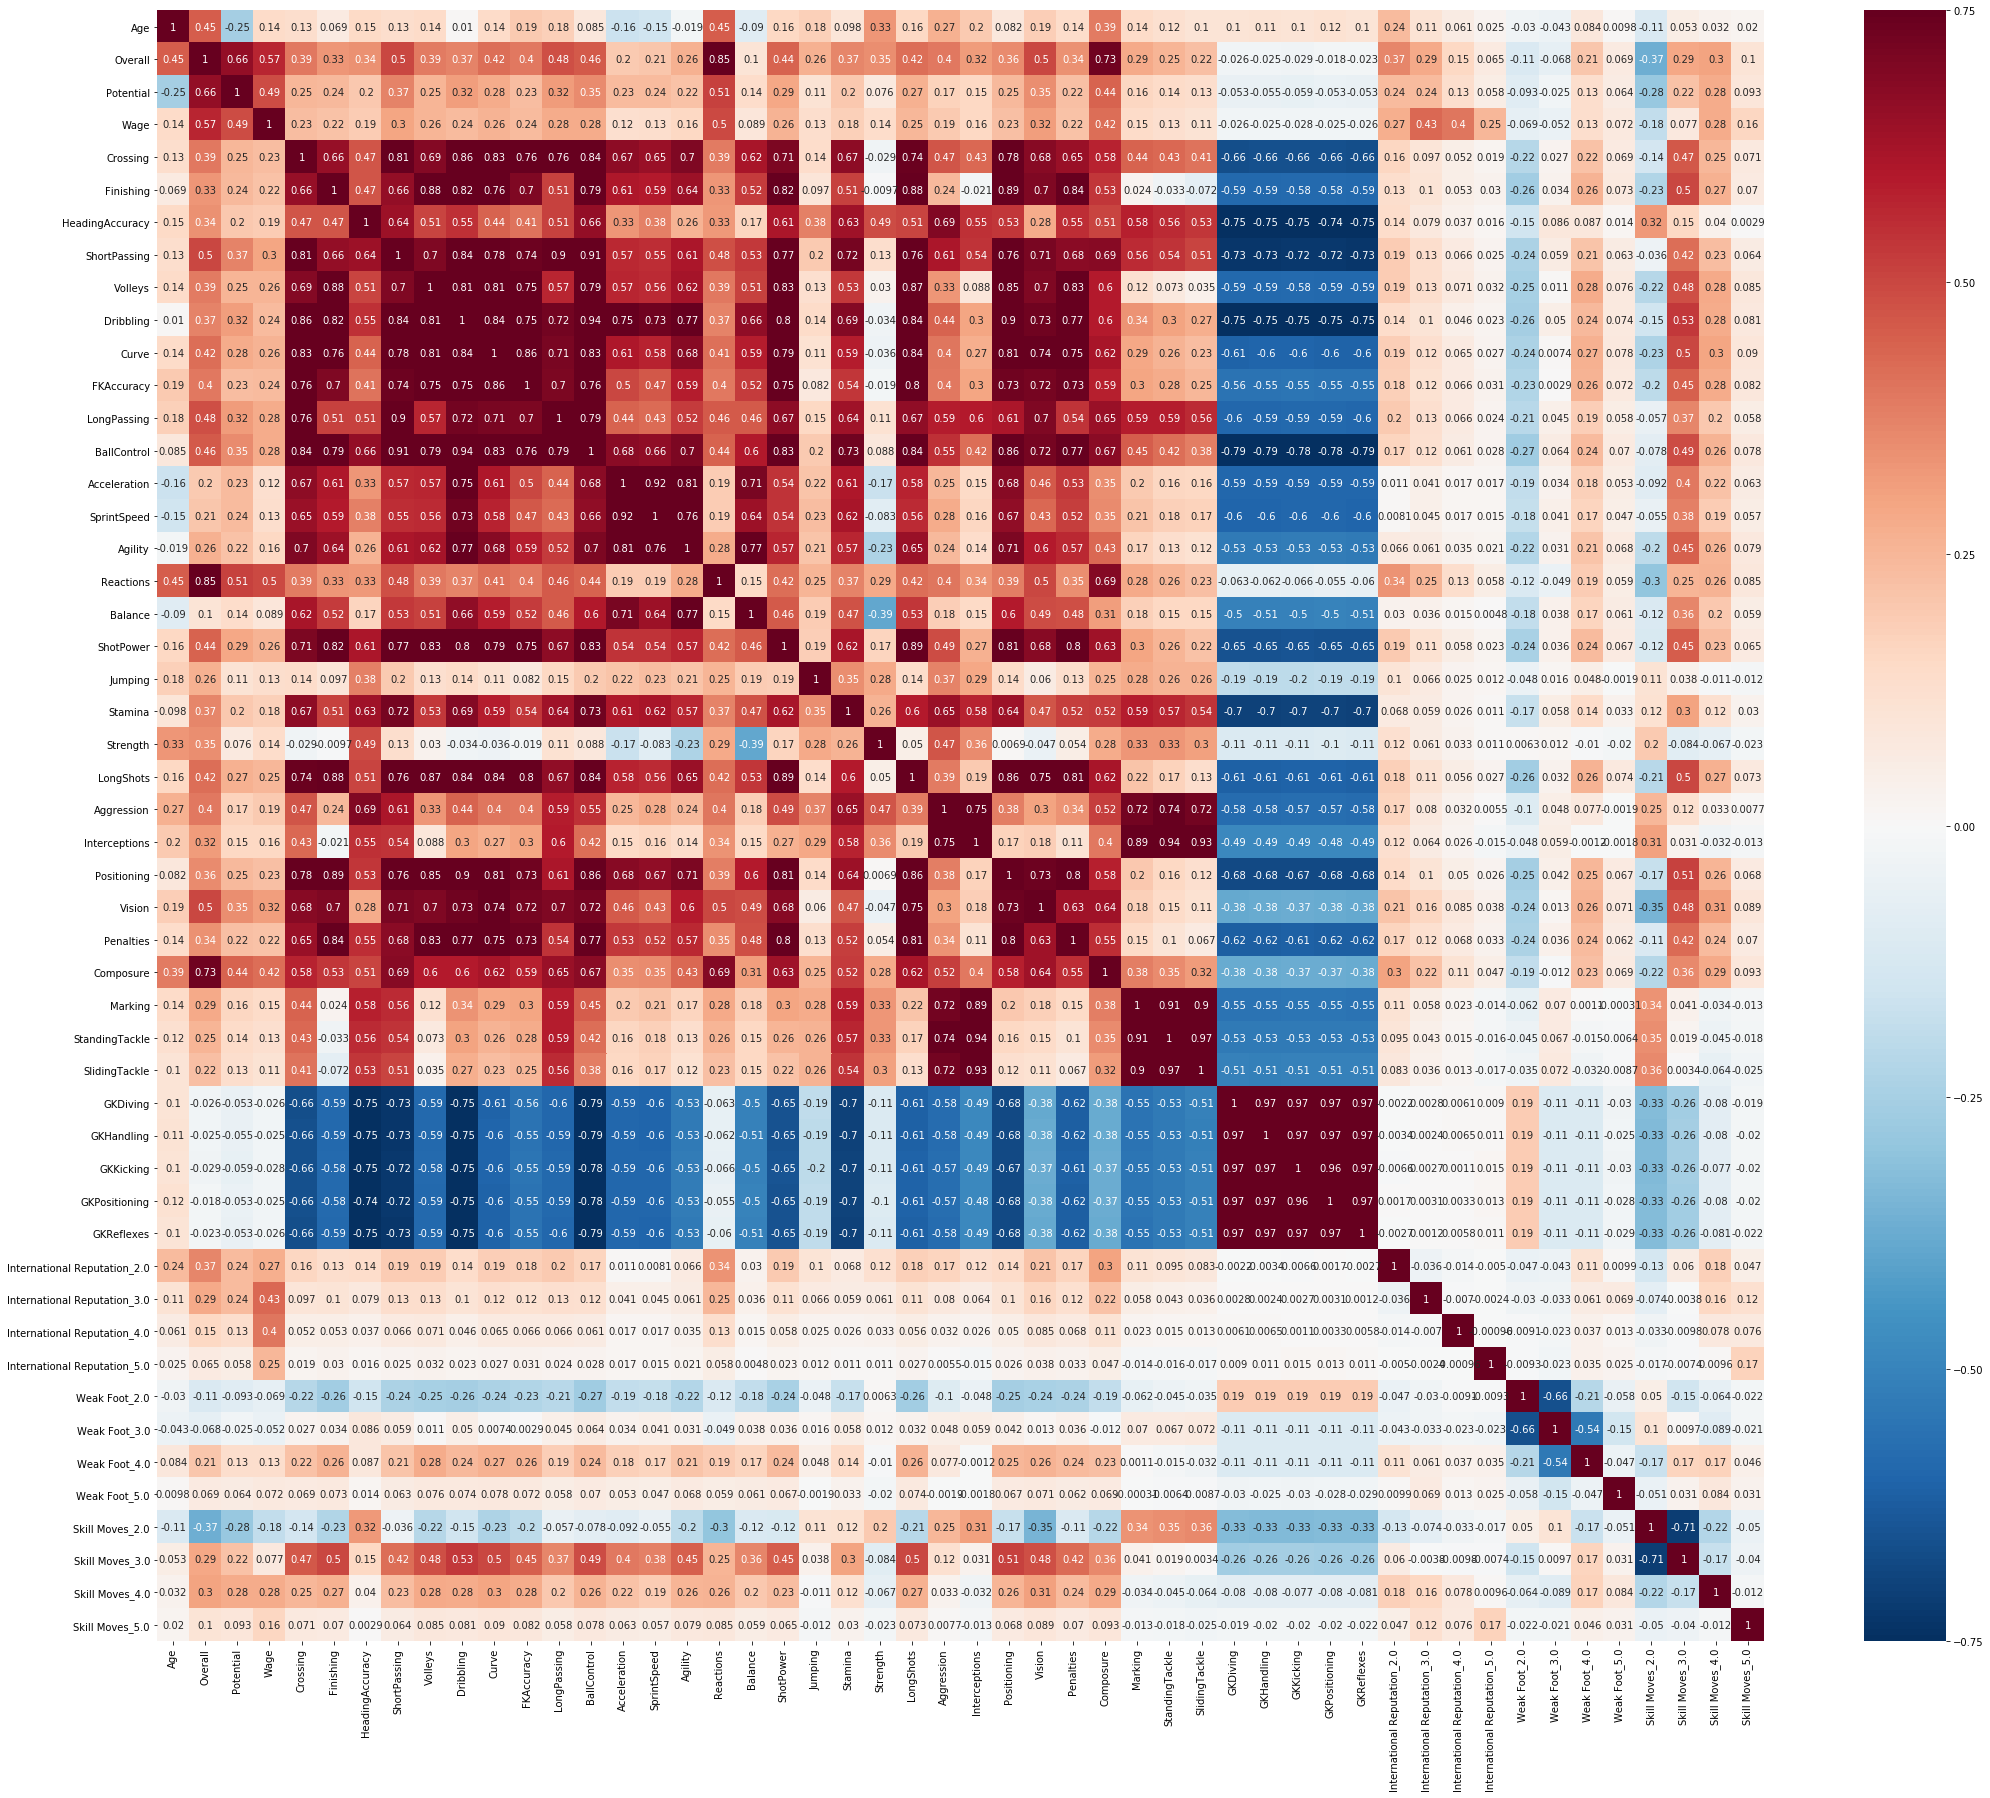

In [31]:
# Shows there is multi collinearity in the data
plt.figure(figsize=(36, 30))
heatmap = sns.heatmap(correlation, annot=True, linewidths=0, vmin=-0.75, vmax=0.75, cmap="RdBu_r")

In [32]:
# Deploying the model
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.9, random_state=31)

# For each Xi, calculate VIF
vif = pd.DataFrame()
vif["Value"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["Features"] = X_train.columns
vif.sort_values(by = ["Value"], ascending = False)

C:\Users\vardh\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1638: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,Value,Features
1,375.615857,Potential
12,245.608809,BallControl
6,216.744934,ShortPassing
13,184.277496,Acceleration
16,179.869352,Reactions
8,164.290406,Dribbling
30,162.480521,StandingTackle
45,157.795817,Skill Moves_2.0
14,146.982199,SprintSpeed
31,128.789237,SlidingTackle


In [33]:
# Loading x_data as per previous step
x_data = fifa_data1.drop(drop_col, axis=1)

# Removing additional columns where we observed high multi collinearity based on VIF values 
# to reduce the multicollinearity effect without affecting the model performace
drop_col2 = ["BallControl", "ShortPassing", "Acceleration", "StandingTackle", "Skill Moves_2.0", 
             "Skill Moves_3.0", "Skill Moves_4.0", "Skill Moves_5.0", "Dribbling", "SlidingTackle", "Vision", "Penalties", 
             "Weak Foot_2.0", "Weak Foot_3.0", "Weak Foot_4.0", "Weak Foot_5.0"]

# Revising independent variables x_data after removing the above columns
x_data.drop(drop_col2, axis = 1, inplace = True)

# Question 1


Randomly split the data into test and training sets such that only 10% of the records are in the training set. Fit a simple linear regression model to predict the overall score of a player and test your model against the test set. Calculate the R^2 for the predictions you made on the test set.

In [34]:
X_train,X_test,y_train,y_test=train_test_split(x_data, y_data, test_size=0.9, random_state=31) 
# Leaves 10% of data to training set.

In [35]:
# Model fitting, OLS
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
model1 = sm.OLS(y_train,X_train).fit()
model1.summary2()

C:\Users\vardh\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\vardh\Anaconda3\lib\site-packages\statsmodels\base\model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\vardh\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\vardh\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\vardh\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
================================================================================
Model:                    OLS                  Adj. R-squared:         0.923    
Dependent Variable:       Overall              AIC:                    7598.9760
Date:                     2020-01-23 20:34     BIC:                    7780.6028
No. Observations:         1815                 Log-Likelihood:         -3766.5  
Df Model:                 32                   F-statistic:            675.8    
Df Residuals:             1782                 Prob (F-statistic):     0.00     
R-squared:                0.924                Scale:                  3.7843   
--------------------------------------------------------------------------------
                              Coef.   Std.Err.    t     P>|t|   [0.025   0.975] 
--------------------------------------------------------------------------------
const                        -12.0201   0.9845 -12.2092 0.0000 -13.9510 -10.0892
Age                            0.5015   0.0178  28.0977 0.0000   0.4665   0.5365
Potential                      0.5276   0.0135  39.1069 0.0000   0.5012   0.5541
Wage                           0.0270   0.0032   8.4646 0.0000   0.0208   0.0333
Crossing                       0.0202   0.0060   3.3482 0.0008   0.0084   0.0320
Finishing                      0.0304   0.0076   3.9923 0.0001   0.0155   0.0454
HeadingAccuracy                0.0575   0.0066   8.7086 0.0000   0.0446   0.0705
Volleys                       -0.0149   0.0069  -2.1423 0.0323  -0.0285  -0.0013
Curve                          0.0136   0.0066   2.0596 0.0396   0.0006   0.0265
FKAccuracy                    -0.0003   0.0058  -0.0532 0.9576  -0.0116   0.0110
LongPassing                    0.0207   0.0063   3.3057 0.0010   0.0084   0.0330
SprintSpeed                    0.0374   0.0057   6.5241 0.0000   0.0262   0.0487
Agility                        0.0216   0.0065   3.3020 0.0010   0.0088   0.0344
Reactions                      0.1538   0.0098  15.7074 0.0000   0.1346   0.1730
Balance                       -0.0078   0.0061  -1.2776 0.2016  -0.0198   0.0042
ShotPower                      0.0150   0.0068   2.2069 0.0274   0.0017   0.0284
Jumping                       -0.0016   0.0047  -0.3415 0.7328  -0.0109   0.0077
Stamina                        0.0291   0.0056   5.2337 0.0000   0.0182   0.0400
Strength                       0.0260   0.0057   4.5246 0.0000   0.0147   0.0373
LongShots                     -0.0058   0.0074  -0.7882 0.4307  -0.0203   0.0087
Aggression                    -0.0019   0.0052  -0.3657 0.7147  -0.0122   0.0084
Interceptions                 -0.0024   0.0058  -0.4126 0.6799  -0.0137   0.0090
Positioning                   -0.0235   0.0070  -3.3701 0.0008  -0.0371  -0.0098
Composure                      0.0531   0.0075   7.0784 0.0000   0.0384   0.0678
Marking                        0.0129   0.0057   2.2660 0.0236   0.0017   0.0240
GKDiving                       0.0476   0.0140   3.3949 0.0007   0.0201   0.0751
GKHandling                     0.0273   0.0138   1.9748 0.0484   0.0002   0.0544
GKKicking                     -0.0146   0.0130  -1.1201 0.2628  -0.0402   0.0110
GKPositioning                  0.0109   0.0138   0.7887 0.4304  -0.0162   0.0379
GKReflexes                     0.0622   0.0134   4.6358 0.0000   0.0359   0.0885
International Reputation_2.0  -0.3046   0.2107  -1.4456 0.1485  -0.7179   0.1087
International Reputation_3.0  -0.9280   0.4187  -2.2165 0.0268  -1.7493  -0.1068
International Reputation_4.0  -2.4537   1.0025  -2.4475 0.0145  -4.4199  -0.4874
International Reputation_5.0   0.0000   0.0000      nan    nan   0.0000   0.0000
--------------------------------------------------------------------------------
Omnibus:                44.933        Durbin-Watson:           2.047            
Prob(Omnibus):          0.000         Jarque-Bera (JB):        50.189           
Skew:  

In [36]:
y_pred = model1.predict(X_test)
print('Accuracy of Linear regression classifier on test set: ', r2_score(y_test, y_pred))

Accuracy of Linear regression classifier on test set:  0.9205285022877294


# Question 2

Using the same training and test sets, fit a simple regression model but with 5-fold cross validation and predict the overall scores of players in the test set. Calculate R^2 for the predictions and compare with the R^2 from question 1. 

In [37]:
# Fitting a simple regression model
lm1 = LinearRegression()
lm1.fit(X_train, y_train)

# Prediction with a 5-fold cross validation
cv_predict = cross_val_predict(lm1, X_test, y_test, cv=5)
cv_r2 = r2_score(y_test, cv_predict)
print(cv_r2)

0.9217989429422655


# Question 3

Using the training data from question 1, fit a Lasso regression to predict the overall scores of players in the test set. Use the default value of alpha (alpha is used to tune the penalty. Higher the value of alpha, fewer the number of features) parameter, which is usually 1.How many features are being used by the model? Calculate the R^2 for the predictions you made on the test set and compare with the R^2 from question 1. 

## Lasso Regression

In [38]:
lasso = Lasso()
lasso.fit(X_train, y_train)
lasso_predict = lasso.predict(X_test)

In [39]:
lasso_train_score = lasso.score(X_train,y_train)

In [40]:
lasso_test_score = lasso.score(X_test,y_test)

In [41]:
lasso.coef_

array([ 0.        ,  0.36797711,  0.44140819,  0.02658841,  0.01710372,
        0.00575474,  0.04801261,  0.        ,  0.00429275,  0.        ,
        0.02260191,  0.02461948,  0.01267   ,  0.18938021, -0.        ,
        0.01014352,  0.        ,  0.02090292,  0.03177623,  0.        ,
        0.        ,  0.        , -0.        ,  0.0690186 ,  0.00805824,
        0.0327316 ,  0.01930386,  0.        ,  0.01353966,  0.05681492,
        0.        , -0.        , -0.        ,  0.        ])

In [42]:
coeff_used = np.sum(lasso.coef_!=0)

In [43]:
print("training score:", lasso_train_score)
print("test score: ", lasso_test_score)
print("number of features used: ", coeff_used)

training score: 0.9183202612847026
test score:  0.9148470280522701
number of features used:  20


# Question 4

Do you expect your answer to question 3 to change if you are using ridge-or log-instead of lasso-penalties?Please explain.

In [44]:
# Uses alpha as the default 1
ridge_model = Ridge().fit(X_train, y_train)
ridge_prediction = ridge_model.predict(X_test)

In [45]:
ridge_train_score = ridge_model.score(X_train, y_train)

In [46]:
ridge_test_score = ridge_model.score(X_test, y_test)

In [47]:
ridge_model.coef_

array([ 0.00000000e+00,  5.00465009e-01,  5.27419990e-01,  2.61279931e-02,
        2.02274204e-02,  3.04685482e-02,  5.76191250e-02, -1.50520454e-02,
        1.36444467e-02, -3.88334919e-04,  2.07191641e-02,  3.73548336e-02,
        2.17003815e-02,  1.53827155e-01, -7.89100650e-03,  1.51095912e-02,
       -1.57102621e-03,  2.91456186e-02,  2.60506491e-02, -5.71842482e-03,
       -1.98613108e-03, -2.27991990e-03, -2.34527527e-02,  5.31279634e-02,
        1.29070242e-02,  4.74468284e-02,  2.73278250e-02, -1.45882732e-02,
        1.11938912e-02,  6.21476267e-02, -2.76145862e-01, -8.24797226e-01,
       -1.91485979e+00,  0.00000000e+00])

In [48]:
coeff_used = np.sum(ridge_model.coef_!=0)

In [49]:
print("training score:", ridge_train_score)
print("test score: ", ridge_test_score)
print("number of features used: ", coeff_used)

training score: 0.9238629245072684
test score:  0.9205355109217317
number of features used:  32


# Question 5

Now try to fit a Lasso regression to predict the overall scores of players with an ideal value for alpha. Your code should try to test different values of alpha and use the ideal one. What, according to your code, is the ideal value of alpha? How many features are being used by the model? Calculate the R^2 for the predictions you made on the test set and compare with the R^2 from question 1. 

In [50]:
lasso2 = Lasso()
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]}
lasso_regressor = GridSearchCV(lasso2, parameters, cv = 5)
lasso_regressor.fit(X_train, y_train)

C:\Users\vardh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2634.5130869415457, tolerance: 7.050861914600552
  positive)
C:\Users\vardh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2630.1631013816755, tolerance: 7.2112264462809925
  positive)
C:\Users\vardh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2697.0296283675475, tolerance: 7.061027203856748
  positive)
C:\Users\vardh\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duali

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1,
                                   5, 10, 20]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [51]:
lasso_regressor.best_params_

{'alpha': 0.001}

In [52]:
lasso_regressor.score(X_train,y_train)

0.9238598017173993

In [53]:
(lasso_regressor.best_estimator_.coef_)

array([ 0.00000000e+00,  4.99967293e-01,  5.27169621e-01,  2.59190490e-02,
        2.02289435e-02,  3.04561211e-02,  5.75642389e-02, -1.50589409e-02,
        1.36013806e-02, -3.72761126e-04,  2.07174822e-02,  3.73319050e-02,
        2.17178768e-02,  1.53832244e-01, -7.89739966e-03,  1.50573262e-02,
       -1.58255095e-03,  2.91927782e-02,  2.60699778e-02, -5.66397416e-03,
       -1.95761394e-03, -2.25809979e-03, -2.34365868e-02,  5.31288130e-02,
        1.28786129e-02,  4.74189006e-02,  2.72831306e-02, -1.44731402e-02,
        1.11442118e-02,  6.21337443e-02, -2.52462337e-01, -7.71769340e-01,
       -1.89230504e+00,  0.00000000e+00])

In [54]:
coeff_used = np.sum(lasso_regressor.best_estimator_.coef_!=0)
print(coeff_used)

32


# Question 6

Calculate AIC and BIC for the models you built in question 1 and question 5. According to each of the measures, which is the better model? Is BIC always greater than AIC? Please explain.Compare the AICs with the corresponding corrected AICs.

In [55]:
# Creating functions to calculate aic / bic
def AIC(y_true, y_hat, coeff_used):
    resid = y_true - y_hat
    sse = sum(resid**2)
    n = len(y_hat)
    return n*np.log(sse/n) + 2*coeff_used

def BIC(y_true, y_hat, coeff_used):
    resid = y_true - y_hat
    sse = sum(resid**2)
    n = len(y_hat)
    return n*np.log(sse/n) + np.log(n)*coeff_used

In [56]:
# aic and bic of simple linear model
aic_lm1 = AIC(y_test, y_pred, (len(X_test.columns)+1))
print(aic_lm1)
bic_lm1 = BIC(y_test, y_pred, (len(X_test.columns)+1))
print(bic_lm1)

21848.994711142073
22118.551275919483


In [57]:
# aic and bic of lasso model
aic_lasso2 = AIC(y_test, lasso_regressor.predict(X_test), (coeff_used+1))
print(aic_lasso2)
bic_lasso2 = BIC(y_test, lasso_regressor.predict(X_test), (coeff_used+1))
print(bic_lasso2)

21838.302602935077
22092.45593543949


In [58]:
# Creating functions to calculate corrected aic
def AICC(y_true, y_hat, coeff_used):
    resid = y_true - y_hat
    sse = sum(resid**2)
    n = len(y_hat)
    return (n*np.log(sse/n) + 2*coeff_used) + (((2*(coeff_used**2))+2*coeff_used)/(n-coeff_used-1))

In [59]:
# Corrected AIC for simple linear models
aicc_lm1 = AICC(y_test, y_pred, (len(X_test.columns)+1))
print(aicc_lm1)

21849.14923652839


In [60]:
# Corrected AIC for lasso models
aicc_lasso2 = AICC(y_test, lasso_regressor.predict(X_test), (coeff_used+1))
print(aicc_lasso2)

21838.440187239186
